In [312]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline  


In [2]:
### Create a class for Value, the nn engine

In [386]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        ## Internal variables
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0* out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self * other
    def __radd__(self, other):
        return self + other
    def __truediv__(self, other):
        return self * other **-1
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return other + (-self)
    def __pow__(self, other):
        # assert(isinstance(other, (int, float)), 'only supports int/float powers')
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad = other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        out = Value(math.exp(self.data),(self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ),'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        

In [272]:
a = Value(2.0)
print((2*a).exp())
print(a)

Value(data=54.598150033144236)
Value(data=2.0)


In [89]:
## Need to be able to add Values and multiply
## e.g a = Value(2.0); b = Value(3.0); a+b => Value(5.0)

In [90]:
a = Value(2.0)
b = Value(3.0)
c = a+b

In [91]:
a.__add__(b)

Value(data=5.0)

In [92]:
c._prev

{Value(data=2.0), Value(data=3.0)}

In [93]:
e = a + a
print(e)
print(e._prev)
print(e._op)

Value(data=4.0)
{Value(data=2.0)}
+


In [94]:
d = a * b
print(d)
print(d._prev)
print(d._op)

Value(data=6.0)
{Value(data=3.0), Value(data=2.0)}
*


In [95]:
## Need to be able to keep track of the previous operation to build a graph. value._prev e.g c = a + b. c._prev == (a, b)

In [96]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create  a rectangular ('record') node for it 
        dot.node(name=uid,label='{ %s | data %.4f | grad %.4f  } ' % (n.label,n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot
    

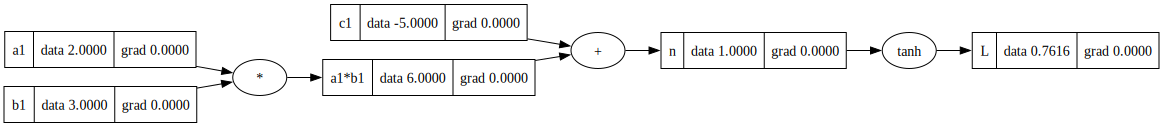

In [143]:
a1 = Value(2.0, label='a1')
b1 = Value(3.0, label='b1')
c1= Value(-5.0, label='c1')
e1 = a1*b1; e1.label='a1*b1'
n = e1 + c1; n.label = 'n'
L = n.tanh(); L.label = 'L'
draw_dot(L)

In [104]:
L.grad = 1.0
L._backward()

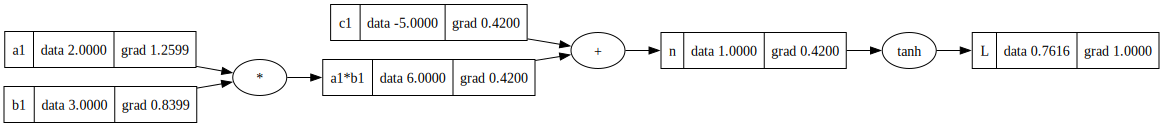

In [146]:
draw_dot(L)

In [106]:
n._backward()

In [145]:
L.backward()

In [113]:
e1._backward()

In [136]:
L.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

for node in reversed(topo):
    node._backward()

In [184]:
x = Value(3.0)

In [169]:
y = x + x

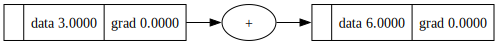

In [170]:
draw_dot(y)

In [171]:
y.backward()

In [185]:
2 * x

Value(data=6.0)

In [162]:
type(x) == Char

NameError: name 'Char' is not defined

In [163]:
z = 1

In [166]:
z if type(x) == Value else Value(z)

1

In [230]:
k = Value(2.0)
k**5

Value(data=32.0)

In [225]:
n

Value(data=0.8813735880195432)

In [232]:
l = Value(3.0)
l.exp()

Value(data=20.085536923187668)

In [279]:
## neuron has inputs and weights
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735880195432, label='b')
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2' 
n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh();
e = (2*n).exp();
o = (e - 1)/ (e + 1)
o.label = 'o'
o.backward()

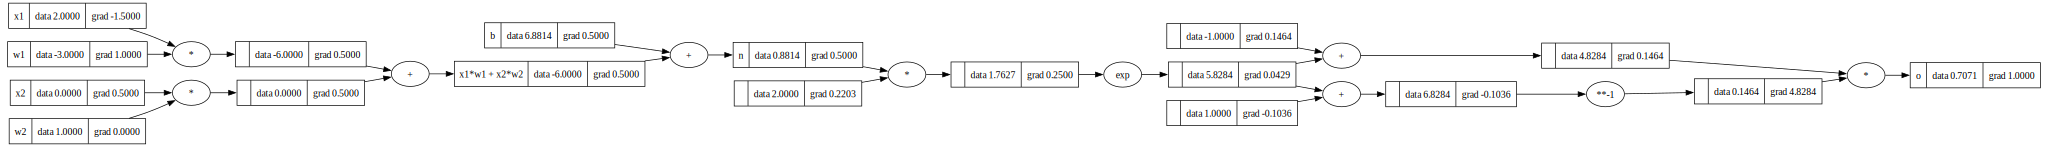

In [280]:
draw_dot(o)

In [284]:
import torch

In [305]:
#implement the same as above in pytorch
x1 = torch.Tensor([2]).double(); x1.requires_grad = True
x2 = torch.Tensor([0]).double(); x2.requires_grad = True

w1 = torch.Tensor([-3]).double(); w1.requires_grad = True
w2 = torch.Tensor([1]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735880195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
o.backward()
print(o.data.item())
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


In [295]:
a = torch.Tensor([[1,2,3],[4,5,6]])

In [296]:
a.shape

torch.Size([2, 3])

In [297]:
a

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [306]:
o.item()

0.7071066904050358

In [547]:
## Neuron class for MLP

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # Forward pass
        # w * x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i] ,sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
            

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.17338850914103174)

In [548]:
xs = [
    [2.0, 3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] # targets

In [549]:
ypred= [n(x) for x in xs]
ypred
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=4.346505316041061)

In [518]:
loss.backward()

In [435]:
n.layers[0].neurons[0].w[0].grad

0.03766496573487106

In [436]:
len(n.parameters())

41

In [519]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [573]:
for i in range(20):
    lr = 0.05
    # Forward pass
    ypred= [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

    # Reset grad
    for p in n.parameters():
        p.grad = 0.0
    # Backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -lr * p.grad # Nudge params in the model
    print(i,loss)

    
    

0 Value(data=0.01005785487032371)
1 Value(data=0.009937821570905777)
2 Value(data=0.0098204410150487)
3 Value(data=0.00970562856314075)
4 Value(data=0.009593303091781791)
5 Value(data=0.009483386814301916)
6 Value(data=0.009375805112121199)
7 Value(data=0.009270486376195288)
8 Value(data=0.0091673618578527)
9 Value(data=0.009066365528381734)
10 Value(data=0.008967433946775879)
11 Value(data=0.008870506135091532)
12 Value(data=0.00877552346091227)
13 Value(data=0.008682429526453317)
14 Value(data=0.008591170063873048)
15 Value(data=0.00850169283639142)
16 Value(data=0.00841394754484362)
17 Value(data=0.00832788573932464)
18 Value(data=0.008243460735604712)
19 Value(data=0.008160627536018629)


In [574]:
ypred

[Value(data=0.9573056886819614),
 Value(data=-0.9505885750387495),
 Value(data=-0.9600447800529701),
 Value(data=0.9520425730529649)]

In [581]:
n([1.0,1.0,0.0])

Value(data=0.14335508680654677)